In [5]:
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspy.embed import AdjacencySpectralEmbed, select_dimension, selectSVD

%matplotlib inline

In [6]:
from graspy.plot import gridplot, heatmap, pairplot, screeplot
from graspy.utils import *
from graspy.utils import get_lcc, pass_to_ranks

plt.style.use("seaborn-white")

folder = Path("20190424_mw_brain_neurons")
adj_df = pd.read_csv(folder / "brain-connectivity-matrix.csv", index_col=0)
adj = adj_df.values

meta_df = pd.read_csv(folder / "brain_meta-data.csv")
meta_df.set_index("ID", inplace=True)
meta_inds = meta_df.index.values
adj_inds = adj_df.index.values

# check that they are sorted the same
(meta_inds == adj_inds).all()



True

array(['CN', 'DANs', 'KCs', 'LHN', 'LHN; CN', 'MBINs', 'MBON', 'MBON; CN',
       'OANs', 'ORN mPNs', 'ORN uPNs', 'tPNs', 'vPNs'], dtype=object)

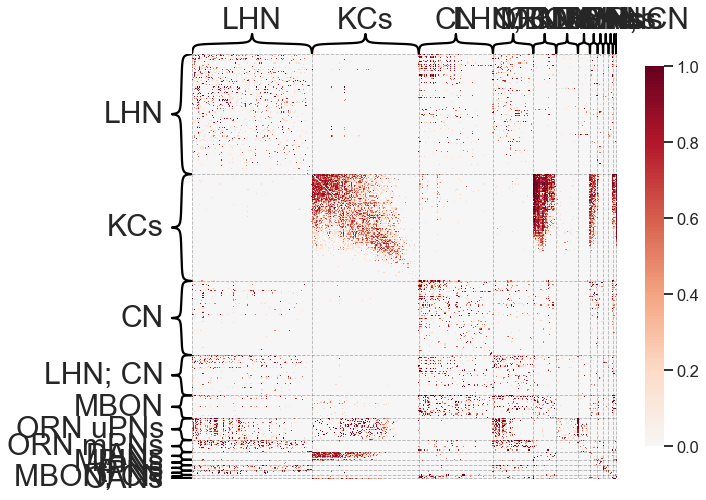

In [7]:
side_labels = meta_df["Hemisphere"].values

# get the subset of cells with type annotations
identified_meta_df = meta_df[meta_df["Class"] != "Unidentified"]
identified_class = identified_meta_df["Class"].values
identified_hemisphere = identified_meta_df["Hemisphere"].values
np.unique(identified_class)
identified_inds = identified_meta_df.index.values

# get those nodes in the graph
graph_mask = np.isin(adj_inds, identified_inds)
identified_adj = adj[np.ix_(graph_mask, graph_mask)]

# Right side
identified_right_meta_df = identified_meta_df[
    identified_meta_df["Hemisphere"] == "right"
]
inds = identified_right_meta_df.index.values
graph_mask = np.isin(adj_inds, inds)
right_adj = adj[np.ix_(graph_mask, graph_mask)]

right_adj, lcc_inds = get_lcc(right_adj, return_inds=True)

right_class = identified_right_meta_df.iloc[lcc_inds, 2].values
heatmap(right_adj, inner_hier_labels=right_class, transform="simple-nonzero")
right_input = identified_right_meta_df.iloc[lcc_inds, 0].values.astype(float)
right_input[right_input == 0] = 1
right_adj = right_adj / right_input[:, np.newaxis].T
a = np.zeros_like(right_adj) + right_input[:, np.newaxis].T


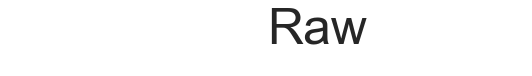

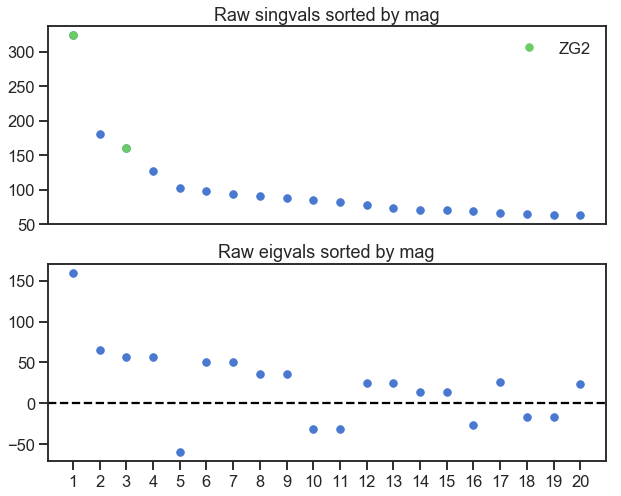

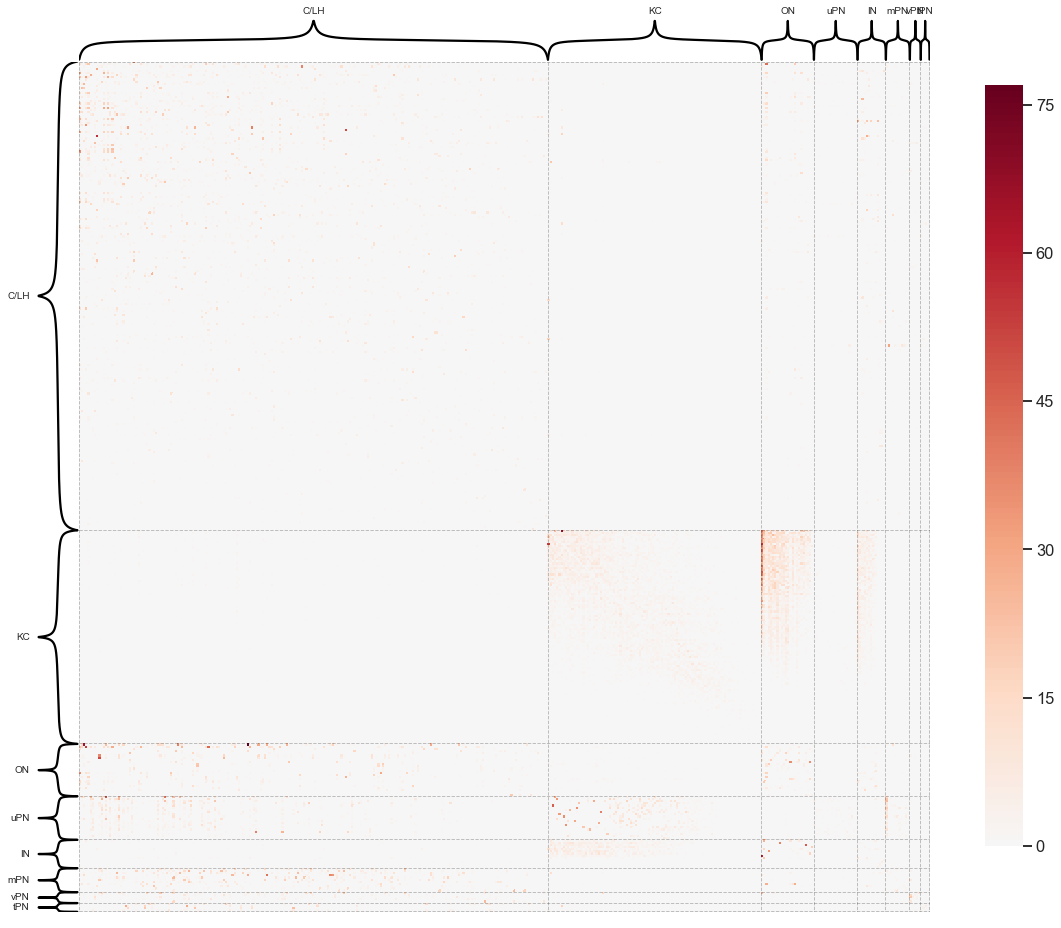

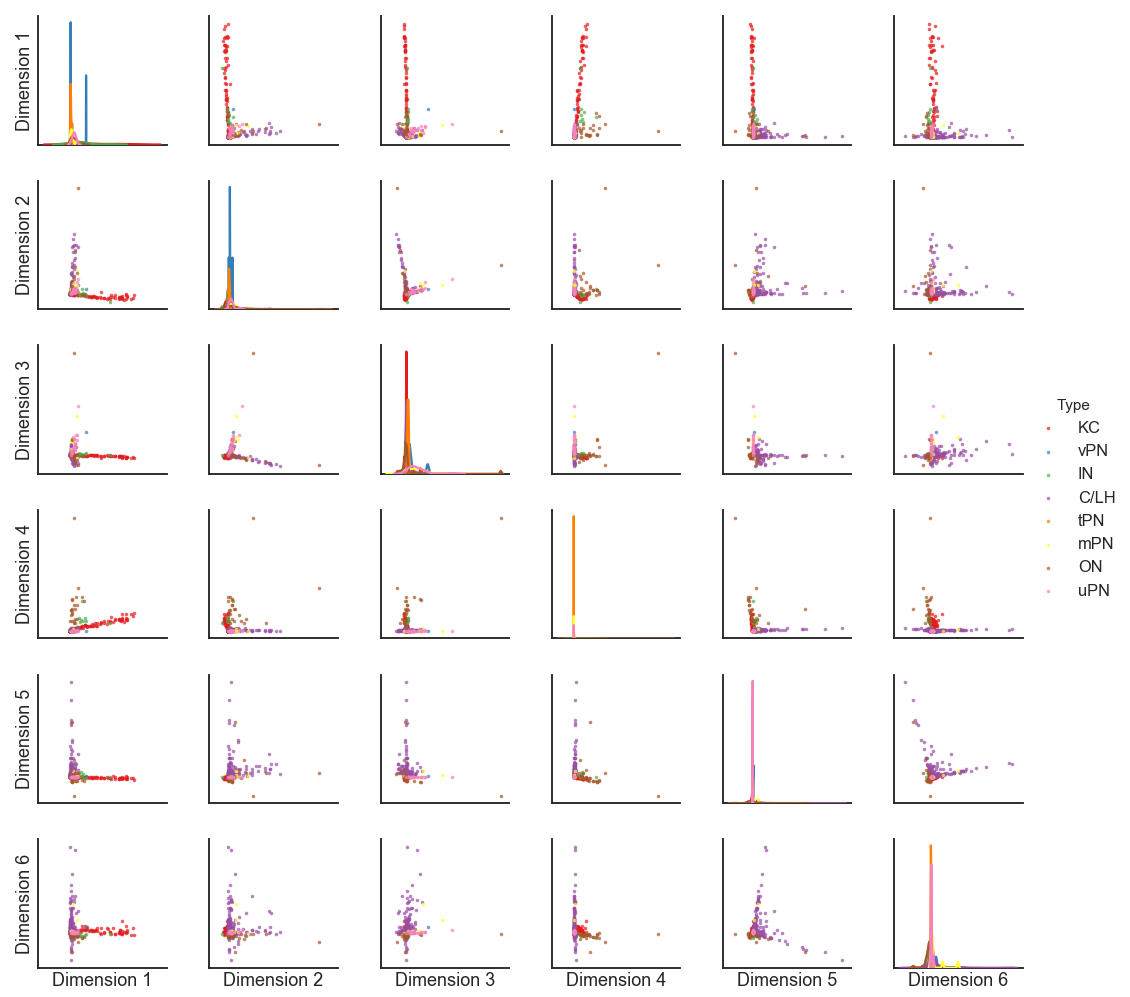

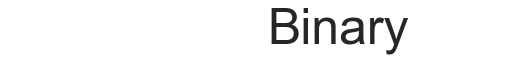

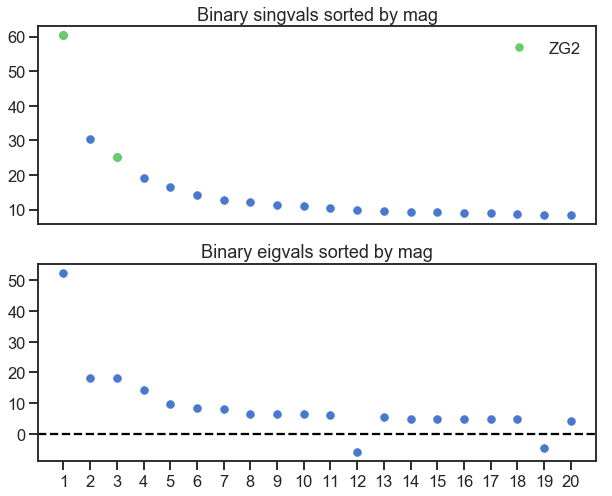

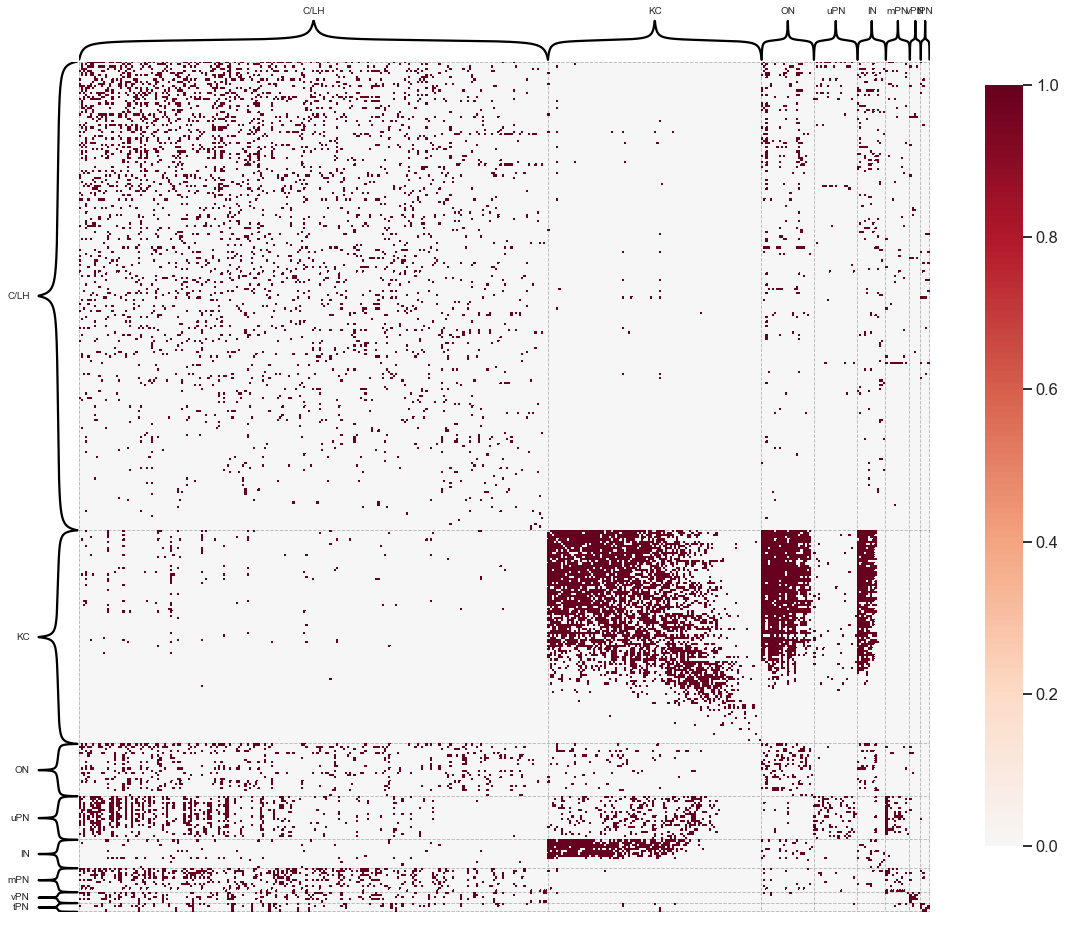

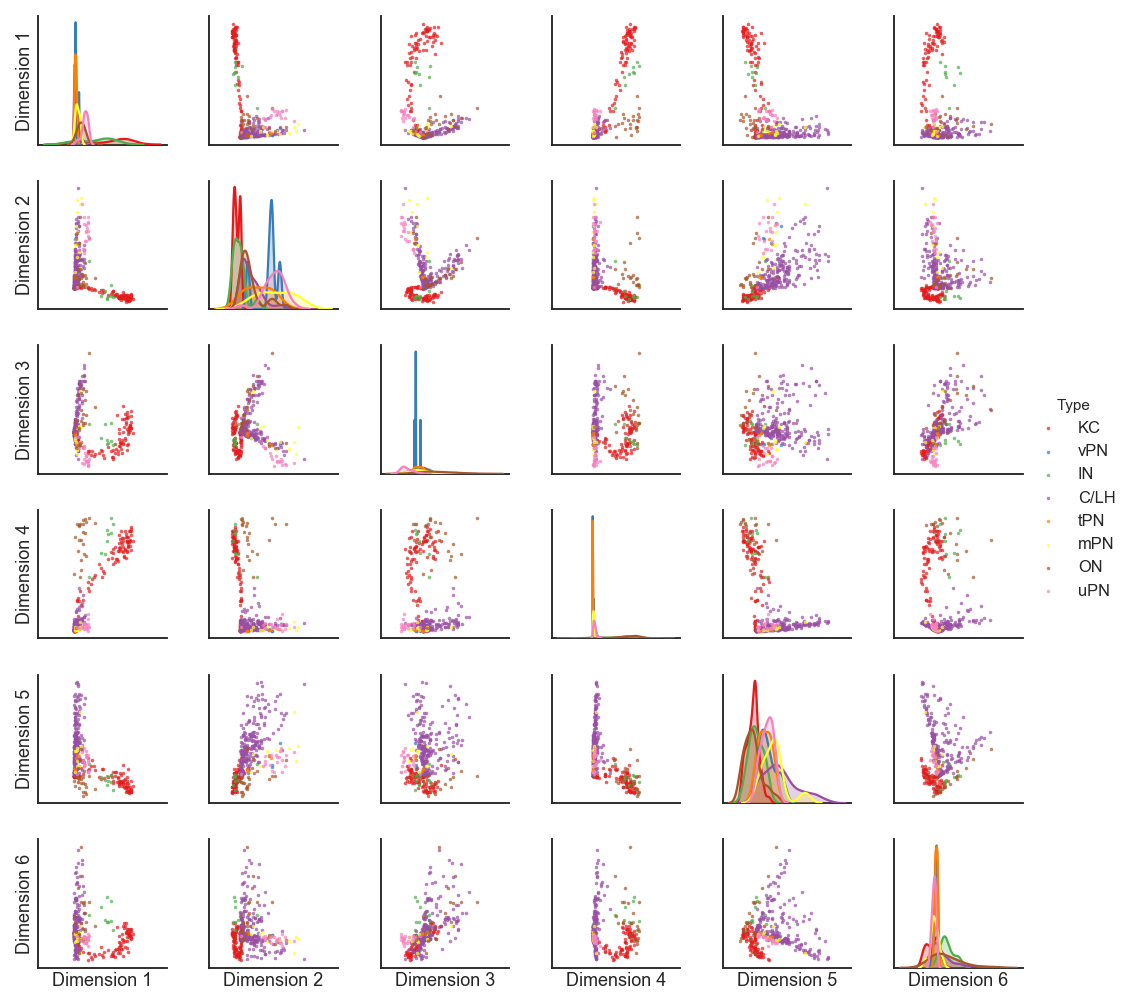

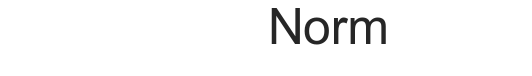

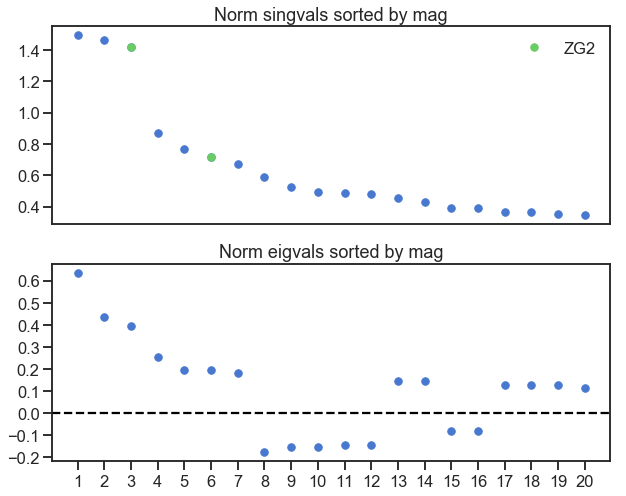

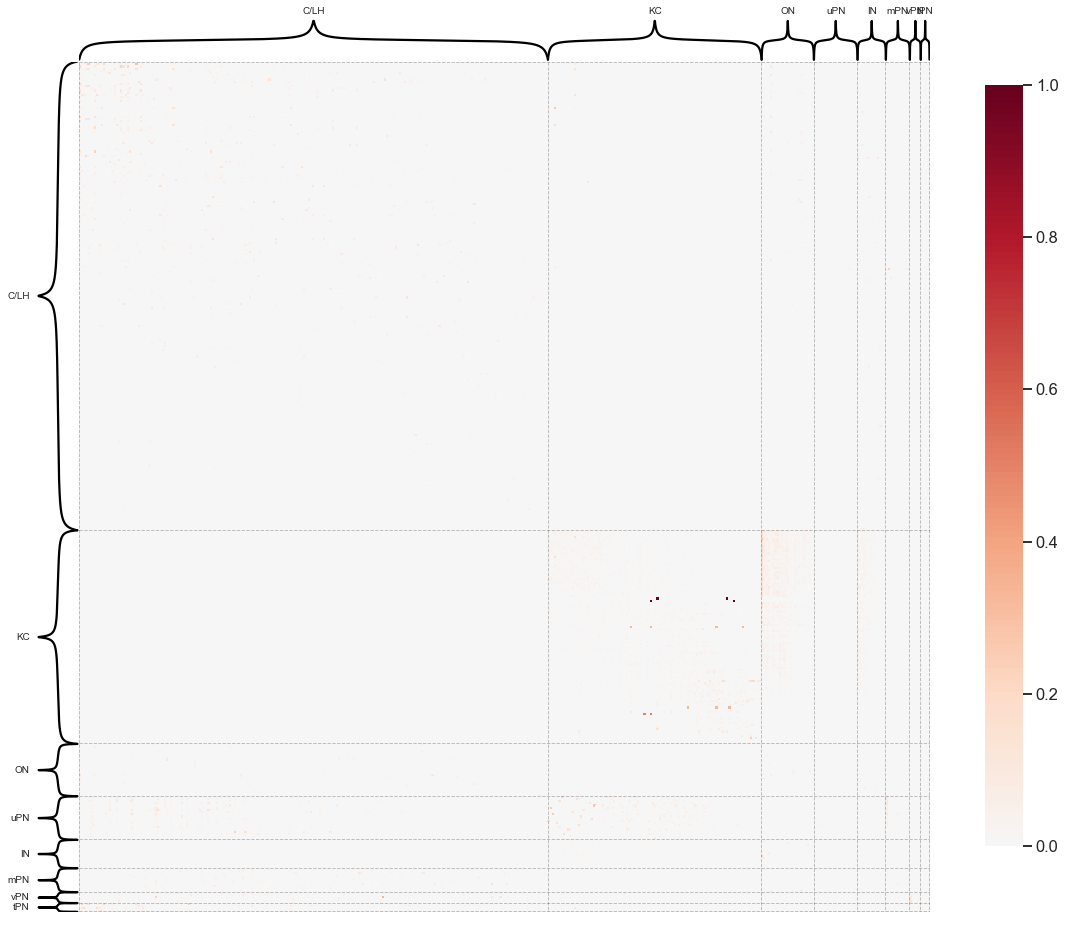

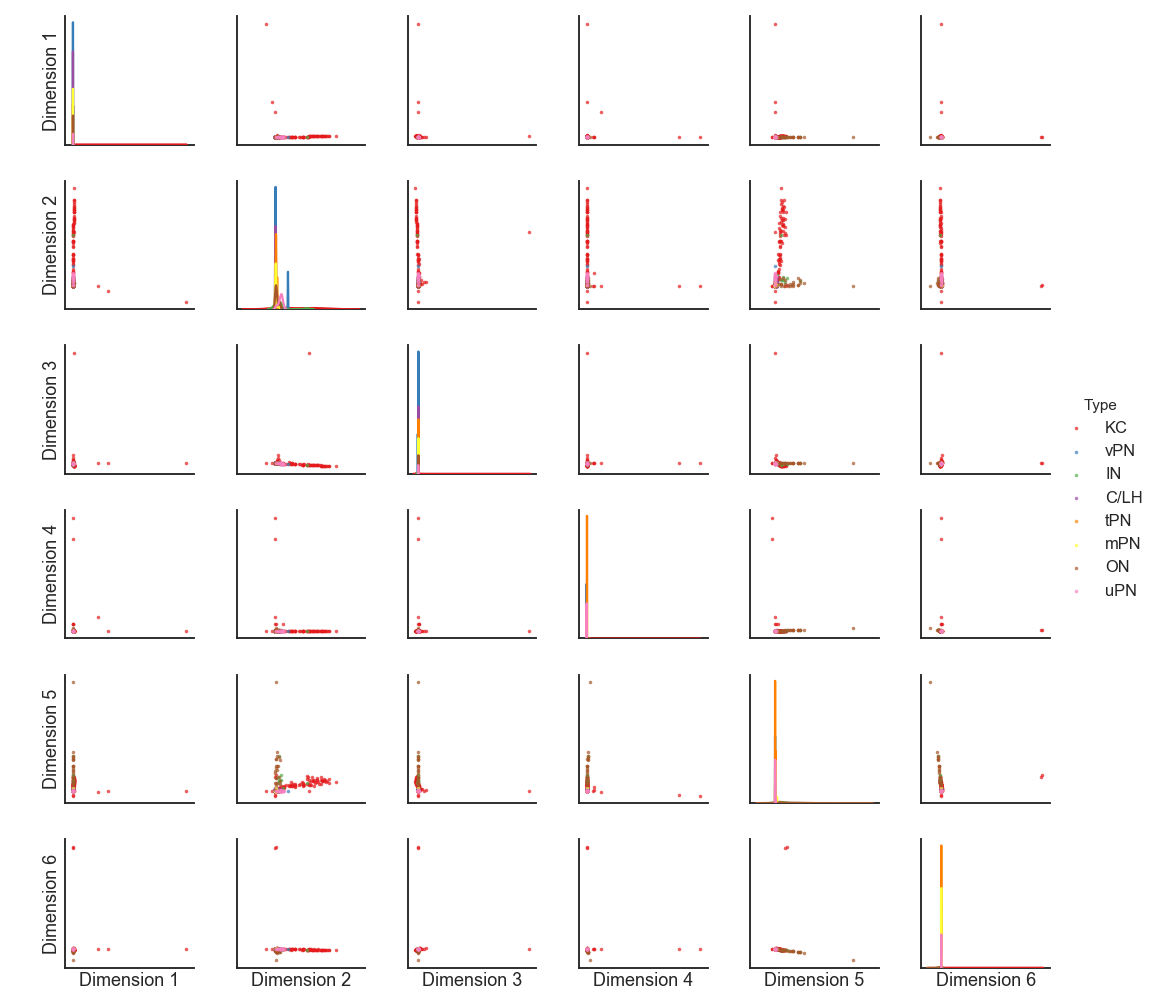

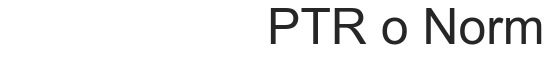

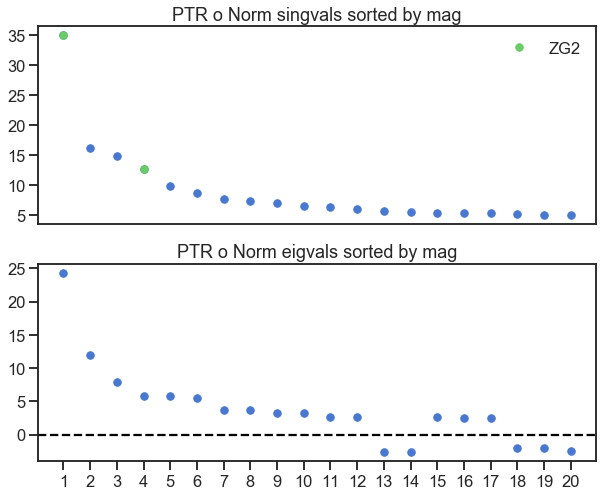

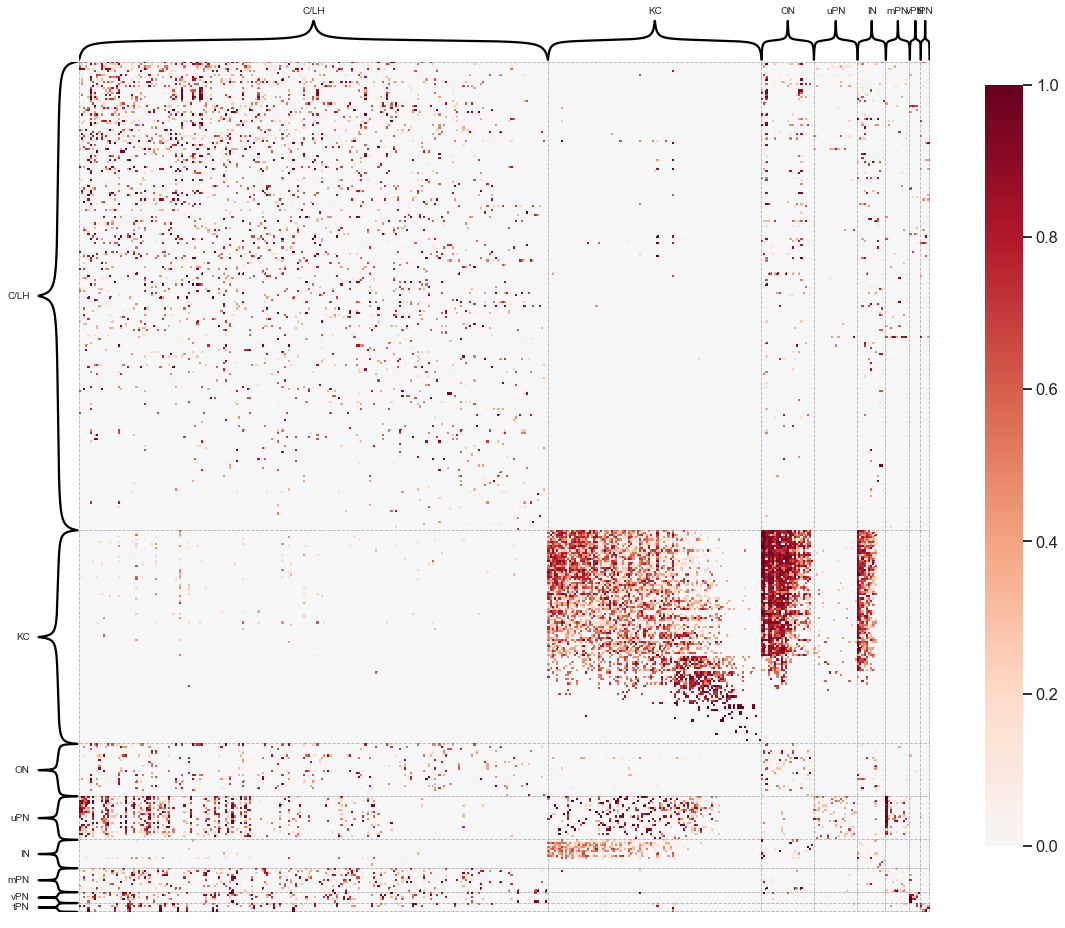

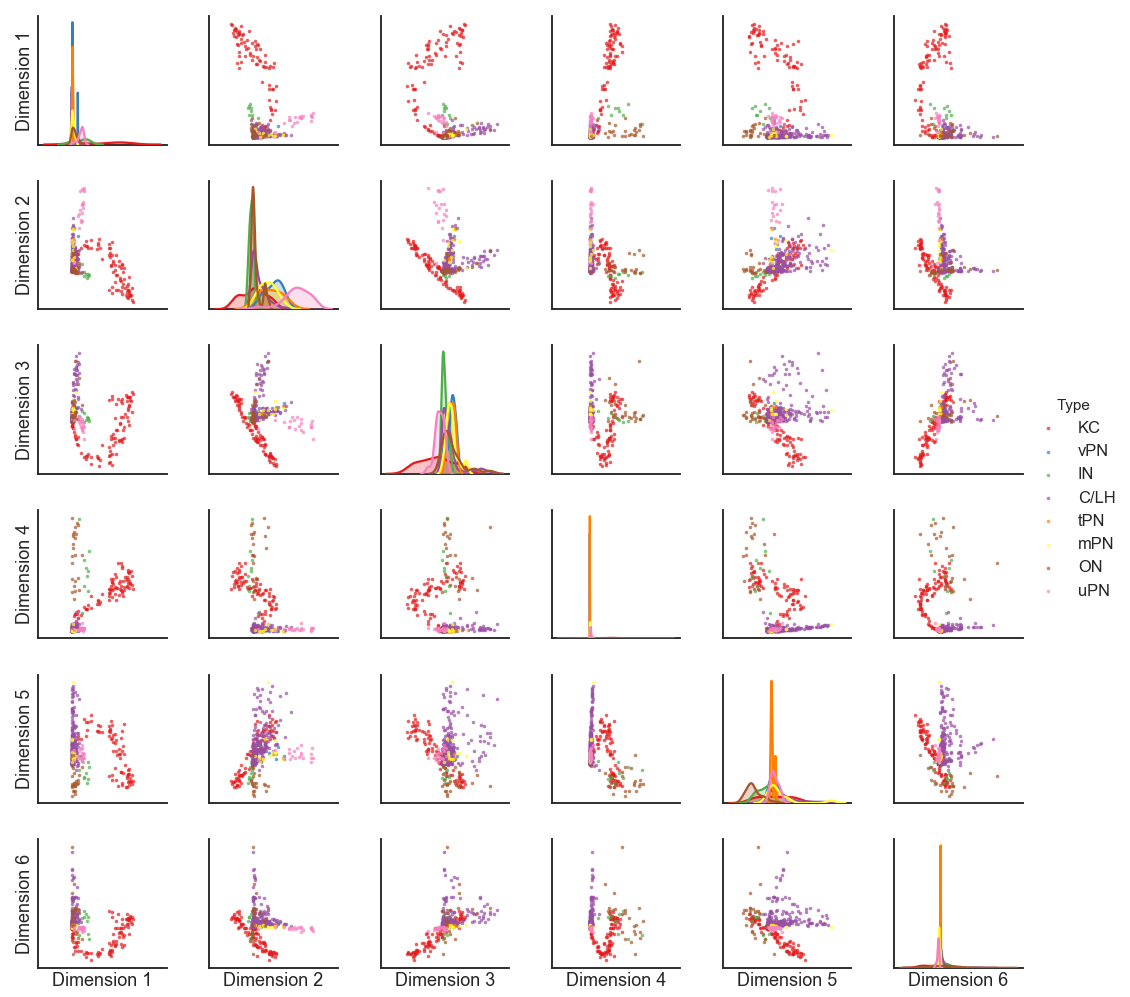

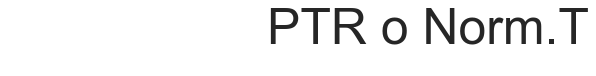

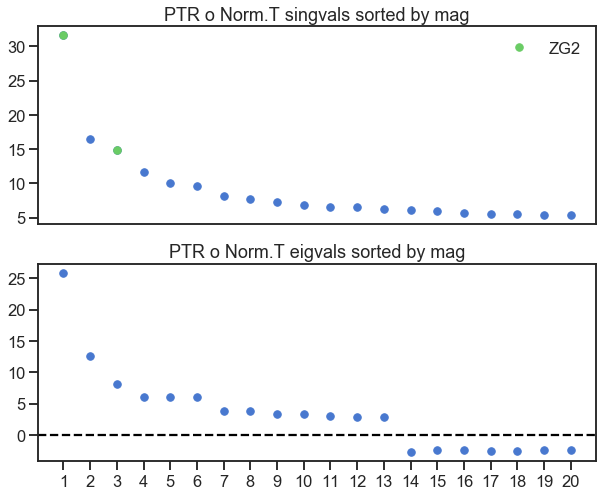

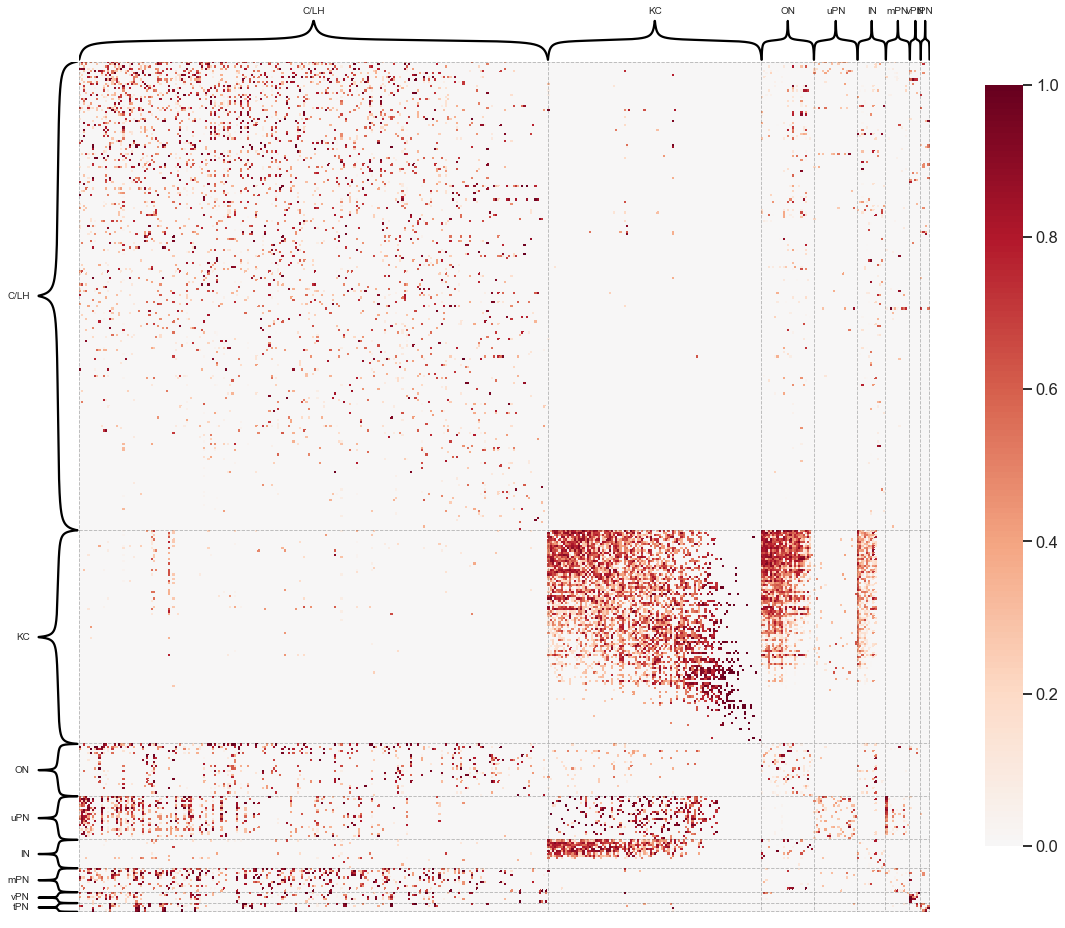

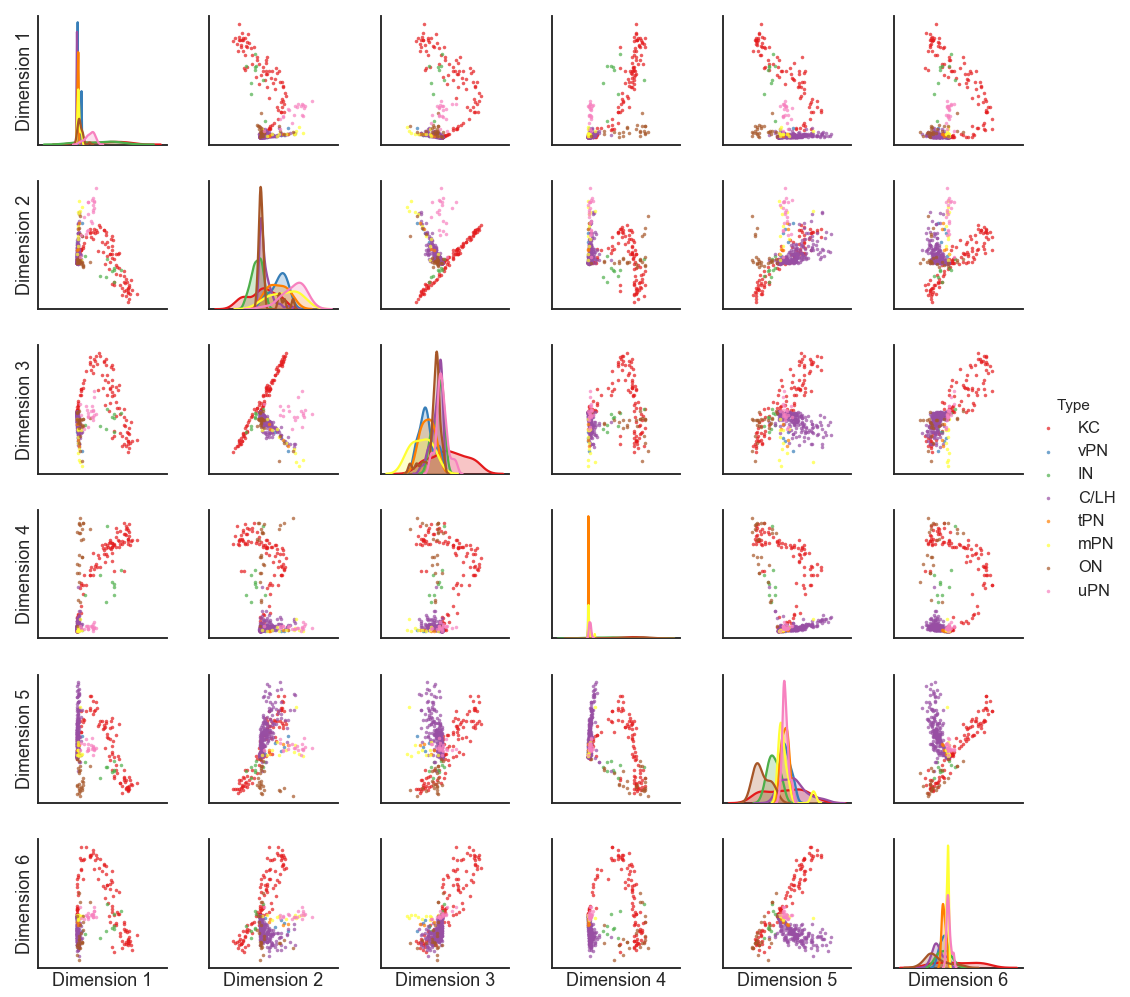

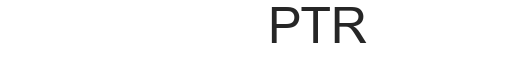

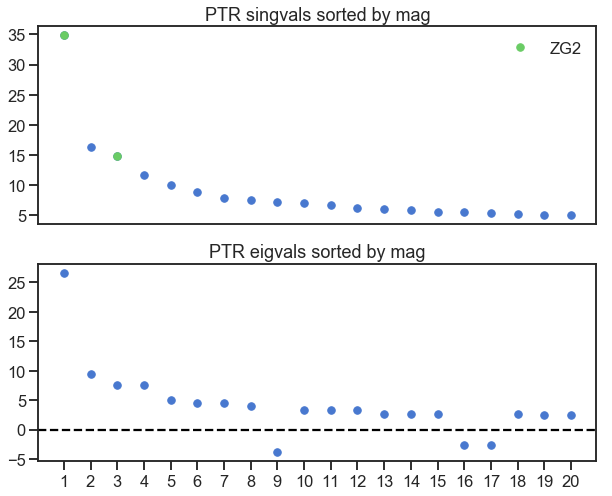

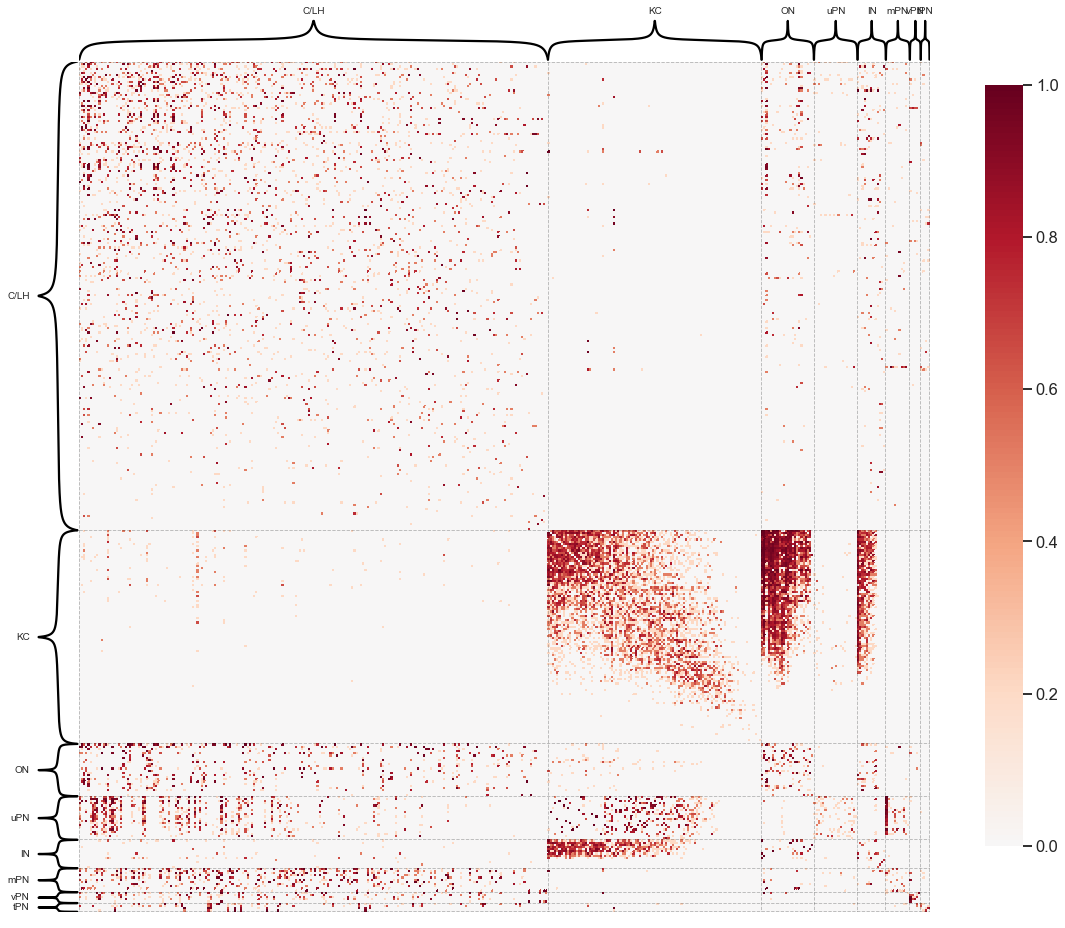

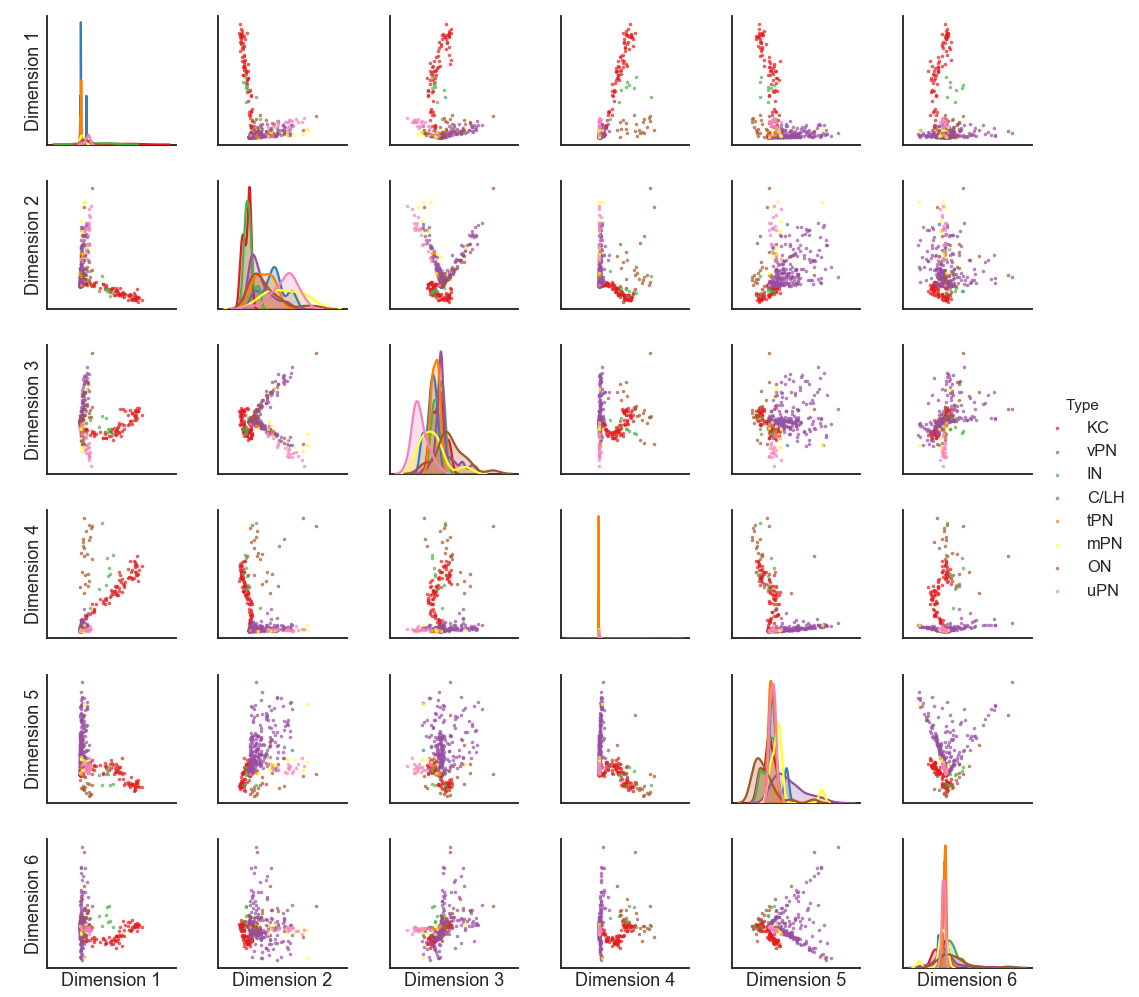

In [16]:
identified_right_meta_df = identified_meta_df[
    identified_meta_df["Hemisphere"] == "right"
]
inds = identified_right_meta_df.index.values
graph_mask = np.isin(adj_inds, inds)
right_adj = adj[np.ix_(graph_mask, graph_mask)]

right_adj, lcc_inds = get_lcc(right_adj, return_inds=True)

right_class = identified_right_meta_df.iloc[lcc_inds, 2].values


# right_adj_norm = right_adj / right_input[:, np.newaxis].T
# right_adj_norm
# heatmap(
#     right_adj_norm,
#     transform="simple-all",
#     inner_hier_labels=right_class,
#     hier_label_fontsize=10,
#     figsize=(20, 20),
# )

# call OANs, DANs, MBINs -> MBIN
# call mPNs are different from uPNs
# tPNs and vPNs are similar to mPNs
# LHN; CN are pretty similar to CN and LHN
# so maybe LHN and CN are the same


def screeplot(mat, title=None, plot_first=20, figsize=(10, 8)):
    plt_kws = {"markersize": 15}
    plt_args = "."
    with sns.plotting_context("talk", font_scale=1):
        fig, ax = plt.subplots(2, 1, figsize=figsize)
        plt.style.use("seaborn-muted")
        _, s, _ = np.linalg.svd(mat)
        ax[0].plot(range(1, plot_first + 1), s[:plot_first], *plt_args, **plt_kws)
        elb_inds, elb_vals = select_dimension(mat)
        ax[0].plot(elb_inds, elb_vals, label="ZG2", *plt_args, **plt_kws)
        ax[0].legend()
        ax[0].set_title(f"{title} singvals sorted by mag")
        ax[0].set_xticks([])
        # plt.figure(figsize=figsize)
        lam, _ = np.linalg.eig(mat)
        lam = np.sort(lam)
        inds = np.argsort(np.abs(lam))
        lam = lam[inds[::-1]]
        ax[1].plot(range(1, plot_first + 1), lam[:plot_first], *plt_args, **plt_kws)
        ax[1].set_title(f"{title} eigvals sorted by mag")
        plt.axhline(0, color="k", linestyle="--")
        ax[1].set_xticks(range(1, plot_first + 1))


identified_right_meta_df = identified_meta_df[
    identified_meta_df["Hemisphere"] == "right"
]
inds = identified_right_meta_df.index.values
graph_mask = np.isin(adj_inds, inds)
right_adj = adj[np.ix_(graph_mask, graph_mask)]

right_adj, lcc_inds = get_lcc(right_adj, return_inds=True)

# remap the names to make them make sense?
name_map = {
    "CN": "C/LH",
    "DANs": "IN",
    "KCs": "KC",
    "LHN": "C/LH",
    "LHN; CN": "C/LH",
    "MBINs": "IN",
    "MBON": "ON",
    "MBON; CN": "ON",
    "OANs": "IN",
    "ORN mPNs": "mPN",
    "ORN uPNs": "uPN",
    "tPNs": "tPN",
    "vPNs": "vPN",
}
right_class = identified_right_meta_df.iloc[lcc_inds, 2].values

# right_adj_norm = right_adj / right_input[:, np.newaxis] # .T?

title = "Raw"
graph = right_adj.copy()
# graph = pass_to_ranks(graph)
right_class = np.array(itemgetter(*right_class)(name_map))


def adjscrepair(graph, title):
    plt.figure(figsize=(9,0.5))
    plt.text(0.5, 0.5, title, fontsize=50)
    plt.axis("off")
    screeplot(graph, title=title)
    heatmap(
        graph, inner_hier_labels=right_class, hier_label_fontsize=10, figsize=(20, 20)
    )
    ase = AdjacencySpectralEmbed(n_components=3)
    latent = ase.fit_transform(graph)
    latent = np.concatenate(latent, axis=1)
    pairplot(latent, labels=right_class)


# right_adj_norm = right_adj / right_input[:, np.newaxis] # .T?
title = "Raw"
graph = right_adj.copy()
# graph = pass_to_ranks(graph)
adjscrepair(graph, title)

title = "Binary"
graph = binarize(right_adj)
adjscrepair(graph, title)

right_adj_norm = right_adj / right_input[:, np.newaxis]  # .T?
title = "Norm"
graph = right_adj_norm.copy()
# graph = pass_to_ranks(graph)
adjscrepair(graph, title)

right_adj_norm = right_adj / right_input[:, np.newaxis]  # .T?
title = "PTR o Norm"
graph = right_adj_norm.copy()
graph = pass_to_ranks(graph)
adjscrepair(graph, title)

right_adj_norm = right_adj / right_input[:, np.newaxis].T  # .T?
title = "PTR o Norm.T"
graph = right_adj_norm.copy()
graph = pass_to_ranks(graph)
adjscrepair(graph, title)

title = "PTR"
graph = right_adj.copy()
graph = pass_to_ranks(graph)
adjscrepair(graph, title)


